In [165]:
%matplotlib inline

#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

import shapely
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import numpy as np

from bot_2d_rep import *

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up a simple robot

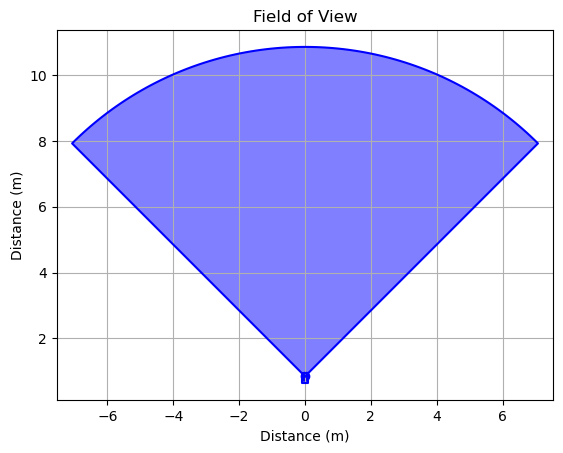

In [166]:
sensor_bounds = Polygon([(.1,.1), (-.1,.1),(-.1,-.2),(.1,-.2)])

sensors = [FOV2D_Simple(hfov=90, distance=10, focal_point=(0,.85), cost=80.00, bounds_polygon=copy.deepcopy(sensor_bounds)),
           FOV2D_Simple(hfov=90, distance=10, focal_point=(-.85,.35), cost=80.00, bounds_polygon=copy.deepcopy(sensor_bounds)).rotate(60),
           FOV2D_Simple(hfov=90, distance=10, focal_point=(-.85,-.35), cost=80.00, bounds_polygon=copy.deepcopy(sensor_bounds)).rotate(120),
           FOV2D_Simple(hfov=90, distance=10, focal_point=(.85,.35), cost=80.00, bounds_polygon=copy.deepcopy(sensor_bounds)).rotate(-60),
           FOV2D_Simple(hfov=90, distance=10, focal_point=(.85,-.35), cost=80.00, bounds_polygon=copy.deepcopy(sensor_bounds)).rotate(-120)]
sensors[0].plot_fov(whole_plot=True)


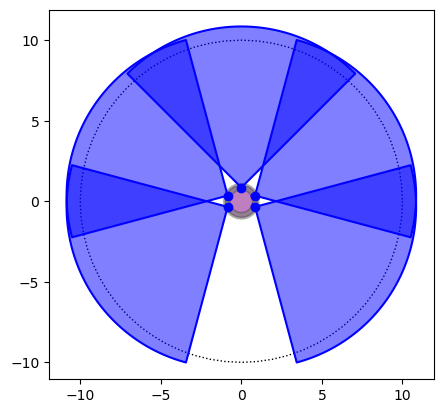

Bot Sensor Package is invalid because sensor is outside of physical constraints.


0.8585654680160784

In [167]:
bot_diam = 1
bot_bounds =  Polygon(shapely.geometry.Point(0, 0).buffer(bot_diam/1).exterior.coords)
sens_constraint = Polygon(shapely.geometry.Point(0, 0).buffer(bot_diam/1-.1).exterior.buffer(0.2))
sense_requirement =  Polygon(shapely.geometry.Point(0, 0).buffer(10).exterior.coords)
bot = SimpleBot2d(bot_bounds, sense_requirement, sensor_pose_constraint=sens_constraint)
bot.add_sensors_2d(sensors)

bot.plot_bot(show_constraint=True)

bot.is_valid()
bot.get_sensor_coverage()

## Rotate a sensor to test

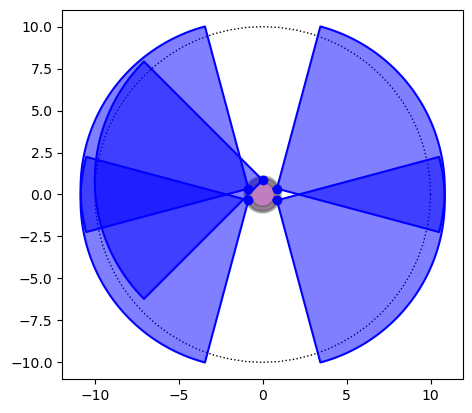

Bot Sensor Package is Valid!


0.7427910703805967

In [168]:
# Rotate the first sensor by 45 degrees
bot.sensors[0].rotate(90)

# Plot the bot with the updated sensor
bot.plot_bot(show_constraint=True)

bot.is_valid()
bot.get_sensor_coverage()

In [169]:
#Rotate the first sensor back...
# bot.sensors[0].rotate(-90)

# Set up the optimization problem

In [170]:
from pymoo.problems.functional import FunctionalProblem

objs = [
    lambda bot: bot.get_sensor_coverage(),
    lambda bot: bot.get_pkg_cost()
]

constr_eq = [
    lambda bot: bot.is_valid()
]

n_var = 10

problem = FunctionalProblem(n_var,
                            objs,
                            constr_eq=constr_eq
                            )

F, G = problem.evaluate(np.array([bot]))

print(f"F: {F}")
print(f"G: {G}")


Bot Sensor Package is Valid!
F: [[  0.74279107 400.        ]]
G: [[1.]]
